In [ ]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE

In [163]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, label_df = utils.load_features(
    data_dir,
    label_scale=1.1,
    # exclude_sources=["sabre"],
    exclude_features=["is_dna", "num_seqs", "seq_length"],
)
clean_feat_names = feat_df.columns.str.replace(":", ".").to_list()
feat_df.columns = clean_feat_names

print(feat_df.shape)
print(drop_df.shape)
print(label_df.shape)

Dropping 0 NaN rows...
(11431, 469)
(11431, 21)
(11431, 1)


In [147]:
# # TEST PERFORMANCE ON WITHHELD DATA
# excluded = "bali3"
# excl_idxs = feat_df.query(f"source == '{excluded}'").index.copy()
# excl_feats = feat_df.loc[excl_idxs].copy()
# excl_labels = label_df.loc[excl_idxs].copy()
# feat_df = feat_df.drop(excl_idxs, axis=0)
# label_df = label_df.drop(excl_idxs, axis=0)
# print(feat_df.shape)
# print(drop_df.shape)
# print(label_df.shape)

In [148]:
# print("max num seqs", drop_df["num_seqs"].max())
# print("max seq len", drop_df["max:seq_length"].max())

In [191]:
from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(
    feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
)
test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
print(len(train_idxs), len(test_idxs), len(valid_idxs))

X_train = feat_df.loc[train_idxs]
X_test = feat_df.loc[test_idxs]
X_valid = feat_df.loc[valid_idxs]
y_train = label_df.loc[train_idxs].iloc[:, 0]
y_test = label_df.loc[test_idxs].iloc[:, 0]
y_valid = label_df.loc[valid_idxs].iloc[:, 0]

9144 1143 1144


In [200]:
param_df = pd.read_parquet(ROOT / "optuna" / "trial_02.parquet")
param_df.head(20)

,score,bagging_freq,learning_rate,colsample_bytree,min_data_in_leaf
0,0.045320,0.524028,0.040065,0.055587,29
1,0.045331,0.417414,0.037295,0.055692,29
2,0.045358,0.864277,0.039063,0.055206,29
3,0.045393,0.618906,0.040448,0.055860,29
4,0.045422,0.561398,0.037036,0.056565,29
5,0.045447,0.996876,0.041744,0.047243,29
6,0.045454,0.646137,0.039973,0.056062,29
7,0.045454,0.709313,0.029329,0.055203,29
8,0.045464,0.725228,0.037546,0.054022,28
9,0.045465,0.554065,0.038028,0.075810,28


In [203]:
import lightgbm as lgb

# Set parameters for regression
# params = {
#     "objective": "rmse",
#     "learning_rate": 0.01,
#     "metric": "l2,l1",
#     "verbosity": 1,
#     # "max_depth": 7,
#     "seed": RSTATE,
#     "num_leaves": 41,
#     # "feature_fraction_bynode": 0.5,
#     "feature_fraction": 0.2,
#     "bagging_fraction": 0.67,
#     # "bagging_freq": 5,
#     # "early_stopping_rounds": 100,
#     "num_threads": 2,
# }
param_df = pd.read_parquet(ROOT / "optuna" / "trial_02.parquet")
params = dict(param_df.drop("score", axis=1).iloc[0])
print(params)
params.update(
    {
        "n_jobs": 1,
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 2000,
        "verbosity": -1,
        "num_leaves": 32,
        "subsample": 0.71,
    }
)
params["bagging_freq"] = None
params["bagging_fraction"] = 0.5240283798776911
for key, val in params.items():
    if isinstance(params[key], float) and (float(int(val)) == val):
        params[key] = int(val)
# Train the model
model = lgb.LGBMRegressor(**params)
model = model.fit(X_train, y_train)

{'bagging_freq': np.float64(0.5240283798776911), 'learning_rate': np.float64(0.04006450012874673), 'colsample_bytree': np.float64(0.05558721002341348), 'min_data_in_leaf': np.float64(29.0)}


In [204]:
y_pred = model.predict(feat_df.loc[valid_idxs])
y_true = label_df.loc[valid_idxs].to_numpy().ravel()
# mask = y_true > 0.1
# y_pred = y_pred[mask]
# y_true = y_true[mask]

# y_pred = model.predict(dnaf_feats)
# y_true = dnaf_labels.to_numpy().ravel()

In [205]:
eps = 1e-2

rmse = (((y_pred - y_true) ** 2).sum() / len(y_true)) ** 0.5
rmspe = (((y_pred - y_true) ** 2 / (y_true + eps)).sum() / len(y_true)) ** 0.5
mae = (np.abs(y_pred - y_true)).sum() / len(y_true)
mape = (np.abs(y_pred - y_true) / (y_true + eps)).sum() / len(y_true)
mape_p50 = np.percentile(np.abs(y_pred - y_true) / (y_true + eps), 50)
corr = np.corrcoef(y_true, y_pred)[0, 1]
print(f"[RMSE] {rmse:.4f}")
print(f"[RMSPE] {rmspe:.4f}")
print(f"[MAE] {mae:.4f}")
print(f"[MAPE] {mape:.4f}")
print(f"[MAPE_P50] {mape_p50:.4f}")
print(f"[CORR] {corr:.4f}")
print(np.sort(np.abs(y_pred - y_true) / (y_true + eps))[::-1][:20])

[RMSE] 0.0432
[RMSPE] 0.1004
[MAE] 0.0262
[MAPE] 0.2565
[MAPE_P50] 0.1628
[CORR] 0.9740
[5.125752   3.23735401 2.56158831 2.22941543 2.05382168 1.96161714
 1.95877368 1.94054849 1.92318091 1.9133737  1.75859069 1.70806002
 1.70678735 1.67821538 1.67322528 1.66847807 1.60023396 1.58710723
 1.54610336 1.50596976]


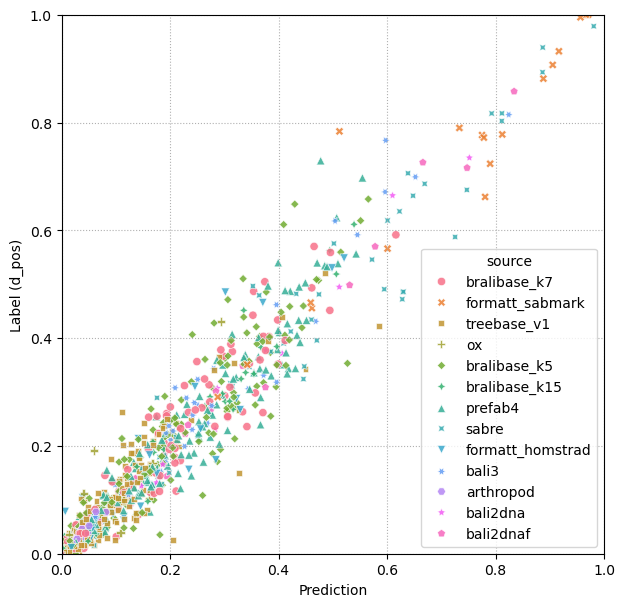

In [206]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[valid_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 7))
sn.scatterplot(x=y_pred, y=y_true, alpha=0.85, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

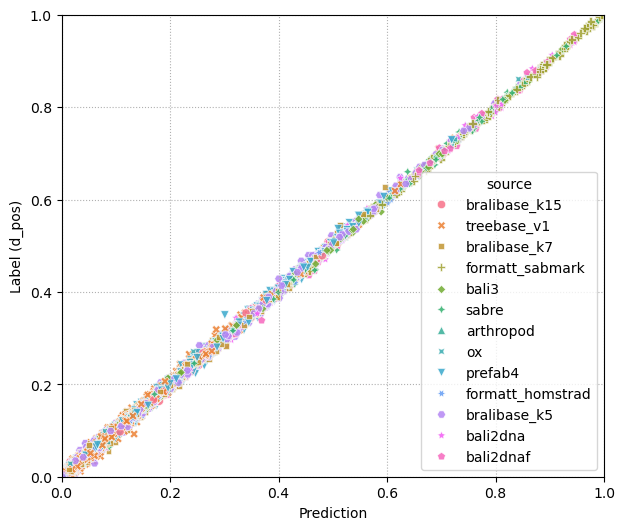

In [170]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[train_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 6))
sn.scatterplot(
    x=model.predict(feat_df.loc[train_idxs]),
    y=label_df.loc[train_idxs].to_numpy().ravel(),
    alpha=0.85,
    style=sources,
    hue=sources,
)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

In [67]:
test = feat_df.copy()
test["label"] = label_df["mean"]
corr = test.corr().loc["label"]
corr = corr.iloc[corr.abs().argsort()[::-1]]
corr[:20]

label                1.000000
p70:tc_base_p50     -0.884982
p70:tc_base_mean    -0.883522
p70:tc_base_min     -0.882288
p60:tc_base_p50     -0.881221
p70:tc_base_max     -0.880806
mean:tc_base_p50    -0.880683
p60:tc_base_mean    -0.880377
mean:tc_base_mean   -0.879720
mean:tc_base_max    -0.879586
p60:tc_base_max     -0.879580
p60:tc_base_min     -0.878223
mean:tc_base_min    -0.877962
p50:tc_base_max     -0.873647
p50:tc_base_p50     -0.873623
p50:tc_base_mean    -0.873135
p80:tc_base_p50     -0.872902
p80:tc_base_min     -0.870997
p50:tc_base_min     -0.870647
p80:tc_base_mean    -0.870593
Name: label, dtype: float64

In [ ]:
imps = model.feature_importances_
imps


# else:
#     imps = model.feature_importances_
# imp_df = pd.DataFrame(dict(feature=feat_df.columns, importance=imps))
# imp_df = imp_df.sort_values("importance", ignore_index=True, ascending=False)
# imp_df[:10]
# imp_df[imp_df.feature.str.contains("mer")].iloc[:10]
# np.save(ROOT / "top_feats.npy", imp_df.feature[:50].to_numpy())

0.0

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

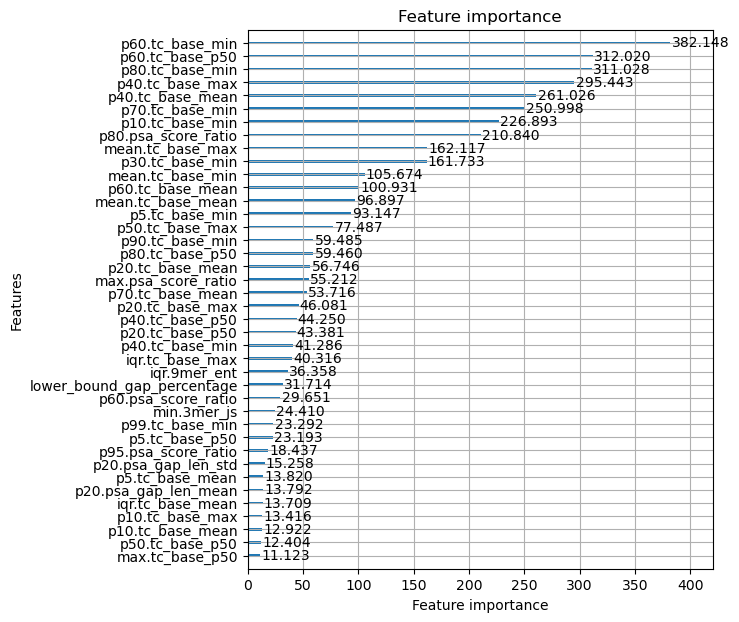

In [176]:
lgb.plot_importance(model, figsize=(6, 7), importance_type="gain", max_num_features=40)
# else:
#     pass
# sn.barplot(x=feat, y=importance[sort_idxs], hue=is_tc)
# ax = plt.gca()
# _ = ax.set_xticklabels([])
# _ = ax.legend(title="Consistency-based")
# _ = ax.set_ylabel("Feature importance")
# _ = ax.set_xlabel("Features")
# print(top_feats[:30])

In [177]:
label_df.sort_values("mean", ascending=False).tail(40)
test_df = label_df.copy().reset_index()
test_df["iszero"] = test_df["mean"] == 0
test_df.groupby(["source"]).mean(numeric_only=True)

,mean,iszero
source,,
arthropod,0.042027,0.000000
bali2dna,0.422209,0.000000
bali2dnaf,0.424904,0.000000
bali3,0.299184,0.000000
bralibase_k15,0.123918,0.262425
bralibase_k5,0.145104,0.290229
bralibase_k7,0.137546,0.285414
formatt_homstrad,0.161023,0.033742
formatt_sabmark,0.740137,0.000000
